<a href="https://colab.research.google.com/github/timkabot/NN-in-arts/blob/main/NN_in_arts_2_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training GANs


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

**Obtain the mighty MNIST**

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

input_size = 784
num_classes = 10

batch_size = 256

train_data = dsets.MNIST(root='./MNIST/', train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_data = dsets.MNIST(root='./MNIST/', train=False, 
                           transform=transforms.ToTensor())


train_data_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                                batch_size=batch_size,
                                                drop_last=True)

test_data_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                               batch_size=batch_size,
                                               drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:07, 1318137.56it/s]                             


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


32768it [00:00, 303013.30it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw


1654784it [00:00, 1907193.23it/s]                            
8192it [00:00, 111026.25it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw
Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


Basic visualization

In [ ]:
import torchvision

def my_imshow(images):
    grid = torchvision.utils.make_grid(images)
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

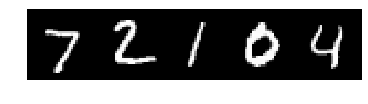

[7 2 1 0 4]


In [ ]:
number_of_samples = 5

images, labels = iter(test_data_loader).next()
images = images[:number_of_samples]
labels = labels[:number_of_samples]

my_imshow(images)
print(labels.numpy())

## Building the Network

### VanillaGAN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

class Generator(nn.Module):
    """
        Vanilla Generator --> fully-connected layers
    """
    def __init__(self, input_size=128, num_classes=784):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        self.input_size = input_size
        
    def forward(self, x):
        output = self.net(x)
        return output.view(-1, 1, 28, 28)

In [ ]:
class Discriminator(nn.Module):
    """
        Vanilla Generator --> fully-connected layers
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        flatten = x.view(x.size(0), -1)
        output = self.net(flatten)
        return output

### Defining the loss function

In [ ]:
def losses(G, D, x_batch, criterion):
    z = torch.randn(batch_size, G.input_size).to(device)
    generated = G(z)

    trues = torch.ones(x_batch.shape[0], 1).to(device)
    falses = torch.zeros(x_batch.shape[0], 1).to(device)
    
    fake = D(generated)
    true = D(x_batch.to(device))
      
    loss_fake, loss_true = criterion(fake, falses), criterion(true, trues)
    D_loss = loss_fake + loss_true
    
    G_loss = criterion(fake, trues)
    
    return D_loss, G_loss
    

### Training process

Keep in mind, that sometimes we are need to train Discriminator and Generator at different speed aka. with different ratios. But for now let's keep it simple.

In [ ]:
from tqdm import trange

def train_epoch(G, D, G_opt, D_opt, criterion, batch_size=32):
    
    G_loss_log = [] 
    D_loss_log = []
    
    G.train()
    for batch_num, (images, _) in zip(trange(len(train_data_loader)), 
                                            train_data_loader):
        x_batch = images.float()
        D_loss, G_loss = losses(G, D, x_batch, criterion)
            
        D_opt.zero_grad()
        D_loss.backward(retain_graph=True)
        D_opt.step()
        
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
            
        D_loss_log += [D_loss.item()]
        G_loss_log += [G_loss.item()]
        
    return D_loss_log, G_loss_log 

#### Implement Test Function

In [ ]:
def test_batch(G, D, criterion):
  
    G_loss_log = [] 
    D_loss_log = []
    
    G.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_data_loader):
        D_loss, G_loss = losses(G, D, x_batch, criterion)
        
        D_loss_log += [D_loss.item()]
        G_loss_log += [G_loss.item()]
    return D_loss_log, G_loss_log 

#### Implement Loss Function Visualisation

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_history[0], label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.title('Discriminator loss')
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_history[1], label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 2], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.title('Model loss')
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.show()

### Finally train

In [ ]:
def train(G, D, G_opt, D_opt, criterion, n_epochs):
    train_log = [[], []]
    val_log = []
    
    for epoch in range(n_epochs):
        train_loss = train_epoch(G, D, G_opt, D_opt, criterion, batch_size=batch_size)
        val_loss = test_batch(G, D, criterion)
        
        train_log[0].extend(train_loss[0])
        train_log[1].extend(train_loss[1])
        
        steps = train_data.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss[0]), np.mean(val_loss[1])))
        
        clear_output()
        plot_history(train_log, val_log)    

Check for GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define Generator & Discriminator & optimizers & criterion

In [ ]:
batch_size

256

In [ ]:
input_size = 128

D = Discriminator().to(device)
G = Generator(input_size).to(device)

NameError: ignored

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

NameError: ignored

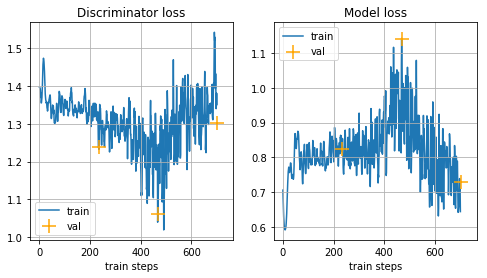

In [ ]:
train(G, D, G_opt, D_opt, criterion, 3)

In [ ]:
number_of_samples = 5

images, _ = iter(test_data_loader).next()
z = torch.randn(number_of_samples, G.input_size).to(device)
gen_images = G(z)
images = images[:number_of_samples]

imshow(images)
imshow(gen_images.detach())


NameError: ignored

resourses: **[eriklindernoren](https://github.com/eriklindernoren/PyTorch-GAN)**, **[Yangyangii](https://github.com/Yangyangii/GAN-Tutorial)**, **aosokin**

# HomeTask 1

Implement a DCGAN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys

In [ ]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(128, n_noise).to(device)

    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [ ]:
class dcGenerator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=128, num_classes=784):
        super(dcGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 4*4*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        self.input_size = input_size
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_)
        return y_

In [ ]:

class dcDiscriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(dcDiscriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [ ]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

# HomeTask 2

Compare the learning process and final images to a fully-connected GAN

In [ ]:

input_size = 128
D = dcDiscriminator().to(device)
G = dcGenerator(input_size).to(device)
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

D_labels = torch.ones([batch_size, 1]).to(device) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(device) # Discriminator Label to fake

In [ ]:
batch_size

256

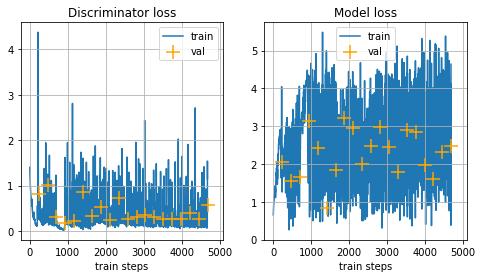

In [ ]:
train(G, D, G_opt, D_opt, criterion, 20)

In [ ]:
def my_imshow(images):
    grid = torchvision.utils.make_grid(images)
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


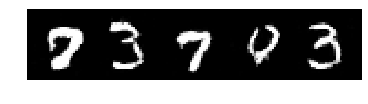

In [ ]:
from matplotlib.pyplot import imshow, imsave

# generation to image
n_noise = 100
G.eval()
z = torch.randn(number_of_samples, G.input_size).to(device)
gen_images = G(z)
gen_images.shape
my_imshow(gen_images.detach())
#imshow(get_sample_image(G, n_noise), cmap='gray')



## A Generative Adversarial Network (GAN) takes the idea of using a generator model to generate fake examples and discrimator model that tries to decide if the image it receives is a fake (i.e. from the generator) or a real sample. This was originally shown with relatively simple fully connected networks.

## A Deep Convolution GAN (DCGAN) does something very similar, but specifically focusses on using Deep Convolutional networks in place of those fully-connected networks. Conv nets in general find areas of correlation within an image, that is, they look for spatial correlations. This means a DCGAN would likely be more fitting for image/video data, whereas the general idea of a GAN can be applied to wider domains, as the model specifics are left open to be addressed by individual model architectures.

## The linked paper that proposed DCGANs specifically raises the topic of unsupervised-learning, and essentially wanted to marry the (at the time) recent success of conv nets with the new idea of GANs.

## Regarding dimensions - I don't think the dimensions of your data would dictate which of the two variants to go for, other than of course influencing things that we always have to consider, such as training time, model complexity, capacity to learn and so on. 

## On such simple dataset as MNIST there isn't big difference in generated images

## Conditional GANs

In [ ]:
class cGenerator(nn.Module):
    """
        Conditional GAN generator --> concated input
    """
    def __init__(self, input_size=100, condition_size=10, num_classes=784):
        super(cGenerator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size+condition_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        self.input_size = input_size
        
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1)
        output = self.net(v)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [ ]:
class cDiscriminator(nn.Module):
    """
        Conditional GAN discriminator --> concated input
    """
    def __init__(self, input_size=784, condition_size=10, num_classes=1):
        super(cDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size+condition_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x, c):        
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1)
        output = self.net(v)
        return output

In [ ]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [ ]:
condition_size = 10

cD = cDiscriminator(condition_size=condition_size).to(device)
cG = cGenerator(input_size, condition_size).to(device)

criterion = nn.BCELoss()
cD_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
cG_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
def losses(G, D, x_batch, labels, criterion):
    z = torch.randn(batch_size, G.input_size).to(device)
    cond = labels.view(batch_size, 1)
    cond = to_onehot(cond).to(device)
    
    generated = G(z, cond)

    trues = torch.ones(x_batch.shape[0], 1).to(device)
    falses = torch.zeros(x_batch.shape[0], 1).to(device)
    
    fake = D(generated, cond)
    true = D(x_batch.to(device), cond)
      
    loss_fake, loss_true = criterion(fake, falses), criterion(true, trues)
    D_loss = loss_fake + loss_true
    
    G_loss = criterion(fake, trues)
    
    return D_loss, G_loss
    

def train_epoch(G, D, G_opt, D_opt, criterion, batch_size=32):
    
    G_loss_log = [] 
    D_loss_log = []
    
    G.train()
    for batch_num, (images, labels) in zip(trange(len(train_data_loader)), 
                                                  train_data_loader):
        x_batch = images.float()
        D_loss, G_loss = losses(G, D, x_batch, labels, criterion)
            
        D_opt.zero_grad()
        D_loss.backward(retain_graph=True)
        D_opt.step()
        
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
            
        D_loss_log += [D_loss.item()]
        G_loss_log += [G_loss.item()]
        
    return D_loss_log, G_loss_log 
  
def test_batch(G, D, criterion):
    G_loss_log = [] 
    D_loss_log = []
    
    G.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_data_loader):
        D_loss, G_loss = losses(G, D, x_batch, y_batch, criterion)
        
        D_loss_log += [D_loss.item()]
        G_loss_log += [G_loss.item()]
    return D_loss_log, G_loss_log 

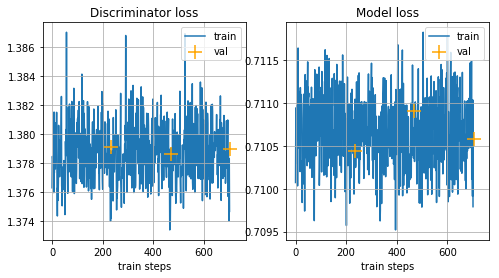

In [ ]:
train(cG, cD, cG_opt, cD_opt, criterion, 3)

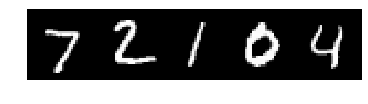

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


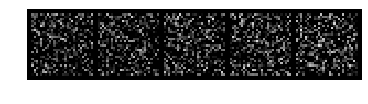

tensor([7, 2, 1, 0, 4])


In [ ]:
number_of_samples = 5

images, labels = iter(test_data_loader).next()
labels = labels[:number_of_samples]
cond = labels.view(number_of_samples, 1)
cond = to_onehot(cond).to(device)
z = torch.randn(num+ber_of_samples, cG.input_size).to(device)
gen_images = cG(z, cond)
images = images[:number_of_samples]

imshow(images)
imshow(gen_images.detach())
print(labels)

# HomeTask 3

Find/implement any other type of GAN ((almost) full list of pytorch implementations [here](https://github.com/eriklindernoren/PyTorch-GAN)). Train chosen GAN on any type of data (preferably something more complicated than MNIST, ideally -- your own dataset: your image class, syntetic images, etc). 

Play with arcitecture choises, number of epochs, otimazers, etc and come up with the model that suits your problem best. Write a conclusion on why the GANs are nessesarily in your task and why chosed GAN is better than everything else. 

## Sent hometask 3 in telegram (Timur Borgalinov -> @timkabor )